In [116]:
from langchain_core.messages import convert_to_messages


def pretty_print_messages(update):
    if isinstance(update, tuple):
        ns, update = update
        # skip parent graph updates in the printouts
        if len(ns) == 0:
            return

        graph_id = ns[-1].split(":")[0]
        print(f"Update from subgraph {graph_id}:")
        print("\n")

    for node_name, node_update in update.items():
        print(f"Update from node {node_name}:")
        print("\n")

        for m in convert_to_messages(node_update["messages"]):
            m.pretty_print()
        print("\n")

In [1]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages


In [2]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

In [3]:
from langchain_groq import ChatGroq
llm = ChatGroq(model='llama-3.3-70b-versatile')

In [4]:
def chatbot(state: State):
    res = {
        "message": llm.invoke(state["messages"])
    }
    return res
    
graph_builder.add_node("chatbot", chatbot)

In [5]:
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

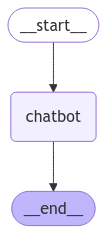

In [6]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [8]:
config = {"configurable": {"thread_id": "1"}}

while True:
  user_input=input("User: ")
  if user_input.lower() in ["quit","q"]:
    print("Good Bye")
    break
  for event in graph.stream({ 'messages': ("user", user_input)}, config, stream_mode="values"):
    print(event.values())


dict_values([[HumanMessage(content='hi', additional_kwargs={}, response_metadata={}, id='e220cdfa-b320-4397-8074-2bb87ab7e67a')]])
Good Bye


In [81]:
def stream_graph_updates(graph, user_input: str):
    """
    Stream updates from the graph for a given user input
    
    Args:
        graph: Compiled LangGraph instance
        user_input: User's input text
    """
    # Create the initial state with messages
    state = {
        "messages": [("user", user_input)]
    }
    
    try:
        # Stream the response
        for event in graph.stream(state):
            if event and isinstance(event, dict):
                for key, value in event.items():
                    if isinstance(value, dict) and "messages" in value:
                        last_message = value["messages"][-1]
                        if isinstance(last_message, tuple) and len(last_message) >= 2:
                            print("Assistant:", last_message[1])
    except Exception as e:
        print(f"Error during streaming: {str(e)}")

In [82]:
while True:
        try:
            user_input = input("User: ")
            if user_input.lower() in ["quit", "exit", "q"]:
                print("Goodbye!")
                break
                
            stream_graph_updates(graph, user_input)
            
        except KeyboardInterrupt:
            print("\nGoodbye!")
            break
        except Exception as e:
            print(f"Error: {str(e)}")
            # Fallback question
            print("Using fallback question...")
            user_input = "What do you know about LangGraph?"
            print("User: " + user_input)
            stream_graph_updates(graph, user_input)
            break


Goodbye!


In [83]:
from langchain_core.tools import tool

@tool
def add(a: int, b: int, state: State) -> int:
    """Adds two numbers."""
    print("---------------->", state)
    return a + b


@tool
def multiply(a: int, b: int, state: State) -> int:
    """Multiplies two numbers."""
    print("---------------->", state)
    return a * b

In [84]:
from typing import Annotated

from langchain_core.tools import tool
from langchain_core.tools.base import InjectedToolCallId
from langgraph.prebuilt import InjectedState
from langgraph.types import Command


def make_handoff_tool(*, agent_name: str):
    """Create a tool that can return handoff via a Command"""
    tool_name = f"transfer_to_{agent_name}"

    @tool(tool_name)
    def handoff_to_agent(
        # # optionally pass current graph state to the tool (will be ignored by the LLM)
        state: Annotated[dict, InjectedState],
        # optionally pass the current tool call ID (will be ignored by the LLM)
        tool_call_id: Annotated[str, InjectedToolCallId],
    ):
        """Ask another agent for help."""
        tool_message = {
            "role": "tool",
            "content": f"Successfully transferred to {agent_name}",
            "name": tool_name,
            "tool_call_id": tool_call_id,
        }
        return Command(
            # navigate to another agent node in the PARENT graph
            goto=agent_name,
            graph=Command.PARENT,
            # This is the state update that the agent `agent_name` will see when it is invoked.
            # We're passing agent's FULL internal message history AND adding a tool message to make sure
            # the resulting chat history is valid. See the paragraph above for more information.
            update={"messages": state["messages"] + [tool_message]},
        )

    return handoff_to_agent

In [85]:
from langgraph.prebuilt import create_react_agent
from langgraph.graph import MessagesState

addition_expert = create_react_agent(
    llm,
    [add, make_handoff_tool(agent_name="multiplication_expert")],
    state_modifier="You are an addition expert, you can ask the multiplication expert for help with multiplication.",
)

multiplication_expert = create_react_agent(
    llm,
    [multiply, make_handoff_tool(agent_name="addition_expert")],
    state_modifier="You are a multiplication expert, you can ask an addition expert for help with addition.",
)

builder = StateGraph(MessagesState)
builder.add_node("addition_expert", addition_expert)
builder.add_node("multiplication_expert", multiplication_expert)
builder.add_edge(START, "addition_expert")
graph = builder.compile()

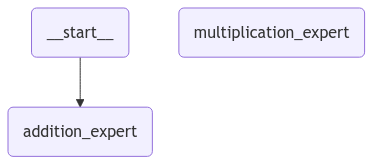

In [86]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [87]:
for chunk in graph.stream(
    {"messages": [("user", "what's (3 + 5) * 12")]}, subgraphs=True
):
    pretty_print_messages(chunk)

Update from subgraph addition_expert:


Update from node agent:


================================== Ai Message ==================================
Tool Calls:
  transfer_to_multiplication_expert (call_qcv8)
 Call ID: call_qcv8
  Args:


----------------> {'messages': []}
Update from subgraph multiplication_expert:


Update from node agent:


================================== Ai Message ==================================
Tool Calls:
  multiply (call_bc8e)
 Call ID: call_bc8e
  Args:
    a: 8
    b: 12
    state: {'messages': []}


Update from subgraph multiplication_expert:


Update from node tools:


================================= Tool Message =================================
Name: multiply

96


Update from subgraph multiplication_expert:


Update from node agent:


================================== Ai Message ==================================

The answer to (3 + 5) * 12 is 96.


